# Análisis de datos

### Instalación de librerías

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importaciones

In [ ]:
import surprise
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import PredefinedKFold
from collections import defaultdict
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import scipy.sparse as sparse
import implicit
import gdown

In [ ]:
# Función para reconocer cuales filas son nulas
def return_nan(dfs):
  return dfs[dfs.isna().any(axis=1)]

## Datasets

#### Last.FM 360k

Se descargan el dataset 'Last.FM 360k' con la información de los usuarios y de las reproducciones de música de cada uno de los usuarios de cierto artista.

In [ ]:
url_lastFM_udata = 'https://drive.google.com/uc?export=download&id=19ZAR0zkWcULEf5oadhtF9BJ9w1iP38w2'
url_lastFM_plays = 'https://drive.google.com/uc?export=download&id=1ksIxr0wQ3JHshOee-rvSZAneyhM5q7lD'

gdown.download(url_lastFM_udata, 'lastFM.udata', quiet=False)
gdown.download(url_lastFM_plays, 'lastFM.plays', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=19ZAR0zkWcULEf5oadhtF9BJ9w1iP38w2
To: /content/lastFM.udata
100%|██████████| 24.6M/24.6M [00:00<00:00, 99.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1ksIxr0wQ3JHshOee-rvSZAneyhM5q7lD
To: /content/lastFM.plays
100%|██████████| 1.64G/1.64G [00:16<00:00, 97.8MB/s]


'lastFM.plays'

Se guardan los datos de cada usuario con su id, genero, edad, país y la fecha de registro.

In [ ]:
lastFM_user_headers = ['user_id', 'gender', 'age', 'country', 'signup']
'''
    usersha1-profile.tsv:
      user-mboxsha1 \t gender ('m'|'f'|empty) \t age (int|empty) \t country (str|empty) \t signup
'''
user_lastFM = pd.read_csv('lastFM.udata', sep='\t',  index_col = 0, names=lastFM_user_headers)

In [ ]:
user_lastFM.head()

,gender,age,country,signup
user_id,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


Se guardan los datos de las reproducciones de cada usuario de un artista, en las columnas se tiene el id del usuario, el id del artista, nombre del artista y cantidad de reproducciones.

In [ ]:
lastFM_play_headers = ['user_id', 'artist_id', 'artist_name', 'plays']
'''
    usersha1-artmbid-artname-plays.tsv:
      user-mboxsha1 \t musicbrainz-artist-id \t artist-name \t plays
'''
plays_lastFM = pd.read_csv('lastFM.plays', sep='\t',  index_col = 0, names=lastFM_play_headers)

In [ ]:
plays_lastFM.head()

,artist_id,artist_name,plays
user_id,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [ ]:
len(plays_lastFM)

17535655

In [ ]:
len(user_lastFM)

359347

In [ ]:
len(plays_lastFM.groupby('artist_id'))

160112

Tenemos que son 359.347 usuarios con 17.535.655 interacciones, a continuación se verán si hay filas nulas y se eliminarán.

In [ ]:
return_nan(user_lastFM)

,gender,age,country,signup
user_id,,,,
00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
0001399387da41d557219578fb08b12afa25ab67,m,NaN,Ukraine,"Aug 17, 2008"
0001a57568309b287363e72dc682e9a170ba6dc2,NaN,23.0,United States,"May 12, 2007"
0001a88a7092846abb1b70dbcced05f914976371,NaN,NaN,Japan,"Oct 13, 2008"
...,...,...,...,...
fff508bfea0e1953ecfe4ec6c635fb9e2ee4b0cc,NaN,NaN,Switzerland,"Jul 5, 2007"
fff6c0fff0e0bc03f7b5a3aa8a538dc9d887fa4a,m,NaN,Poland,"Mar 25, 2008"
fff89b6b5332f0f38996f11c88f908a3924926fe,m,NaN,United States,"Jun 6, 2009"


En la tabla user_lastFM se puede ver que hay 91.964 usuarios que les faltan datos de edad o genero, por lo que se eliminarán estos.

In [ ]:
user_lastFM = user_lastFM.dropna()
user_lastFM

,gender,age,country,signup
user_id,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"
0000c176103e538d5c9828e695fed4f7ae42dd01,m,20.0,United Kingdom,"Jan 14, 2006"
0000ee7dd906373efa37f4e1185bfe1e3f8695ae,m,17.0,Finland,"Nov 17, 2007"
...,...,...,...,...
fffe7823f67b433b45f22056467db921c1d3d7d0,m,25.0,Germany,"Jun 24, 2006"
fffe8637bd8234309e871409c7ebef99a720afc1,m,25.0,Brazil,"Sep 9, 2007"
fffe8c7f952d9b960a56ed4dcb40a415d924b224,m,20.0,United States,"Aug 8, 2007"


Al eliminar los usuarios con datos nulos, se tienen un total de 267.383 usuarios.

Al agrupar los usuarios de Last.FM por edad tenemos que claramente hay usuarios con edad no válida, y solo consideraremos como válida aquellos con edad entre 0 y 100 años.

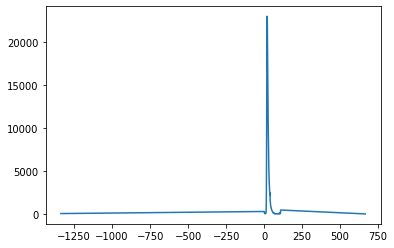

In [ ]:
lastFM_users_by_age = user_lastFM.groupby('age').size().to_frame('count_age')
plt.plot(lastFM_users_by_age)

Se eliminarán los usuarios con edad no válida:

In [ ]:
user_lastFM = user_lastFM[user_lastFM.age <= 100] #eliminar los mayores de 100
user_lastFM = user_lastFM[user_lastFM.age > 0] #eliminar los menores de 0

In [ ]:
user_lastFM.age.describe()

count    266482.000000
mean         24.987050
std           8.082451
min           1.000000
25%          20.000000
50%          23.000000
75%          28.000000
max         100.000000
Name: age, dtype: float64

Luego, en plays_lastFM se utilizarán las interacciones/filas que tengan solo los usuarios de los datos después de la limpieza.

In [ ]:
plays_lastFM = plays_lastFM[plays_lastFM.index.isin(user_lastFM.index.values)]
plays_lastFM

,artist_id,artist_name,plays
user_id,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
...,...,...,...
ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,7e482754-d3f6-49e5-b351-235849754e26,tristania,61
ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,656a0800-3a2b-47ed-a3ff-1e2908fdd2ff,xandria,61
ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,4d7928cd-7ed2-4282-8c29-c0c9f966f1bd,alice cooper,59


Se puede notar como las 17.535.655 filas que tenian, disminuyeron a 13.024.195

A continuación, se verá en plays_lastFM, si hay filas nulas, y se procederá a eliminar estas si existen.

In [ ]:
return_nan(plays_lastFM)

,artist_id,artist_name,plays
user_id,,,
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,NaN,rock universal,14
00007a47085b9aab8af55f52ec8846ac479ac4fe,NaN,apes & androids,67
0000f687d4fe9c1ed49620fbc5ed5b0d7798ea20,NaN,fondo flamenco,3
0001bd96207f323b53652bf400702719ad456d3c,NaN,ambassadöör,55
00026e8fc41980c9605eac741cd97b8216d2dbbd,NaN,cali lewis,89
...,...,...,...
fffe356b9dab2fae1f887fabb1f08ab4976c91bb,NaN,martingo,73
fffe454af08a58c7bafe77491b586711f6b5e6f1,NaN,eric clapton and steve winwood,26
fffe7823f67b433b45f22056467db921c1d3d7d0,NaN,big city beats,52


Hay 166.739 filas que tienen valores nulos en plays_lastFM, por lo que, se eliminaran estas de plays_lastFM.

In [ ]:
plays_lastFM = plays_lastFM.dropna()
plays_lastFM

,artist_id,artist_name,plays
user_id,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
...,...,...,...
ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,7e482754-d3f6-49e5-b351-235849754e26,tristania,61
ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,656a0800-3a2b-47ed-a3ff-1e2908fdd2ff,xandria,61
ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,4d7928cd-7ed2-4282-8c29-c0c9f966f1bd,alice cooper,59


Hay un usuario que claramente era incorrecto en la tabla original(el usuario con id 'sep 20, 2008'), sin embargo, al hacer la limpieza anterior, se logró el eliminar este.

Con la limpieza anterior, se tiene que en la tabla plays_lastFM de 17.535.655 interacciones/filas, al eliminar las filas con usuarios no válidos quedaron 13.024.195, y al eliminar los valores nulos quedaron 12.857.456 interacciones/filas.

Se guardan los dataframe en archivos csv.

In [ ]:
user_lastFM.to_csv('lastFM_users.csv')
plays_lastFM.to_csv('lastFM_plays.csv')

Al agrupar los usuarios de Last.FM por genero tenemos que:

In [ ]:
lastFM_users_by_gender = user_lastFM.groupby('gender').size().to_frame('count_gender')
lastFM_users_by_gender

,count_gender
gender,
f,69205
m,197277


Se tienen 69.205 usuarios femeninos y 197.277 masculinos. Por lo que, la mayoría de los usuarios del dataset son masculinos, siendo estos casi el triple de los usuarios femeninos.

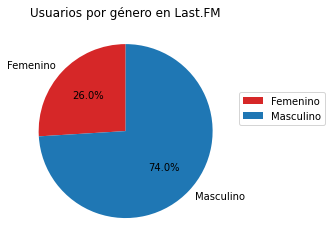

In [ ]:
fig, ax = plt.subplots()

gender = ['Femenino', 'Masculino']
bar_colors = ['tab:red', 'tab:blue']
ax.pie(lastFM_users_by_gender['count_gender'], autopct='%1.1f%%',
       labels=gender, startangle=90, colors=bar_colors)

ax.set_title('Usuarios por género en Last.FM', loc='center')
angle = np.deg2rad(0.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))
plt.savefig('lastFM_usuarios_by_gender.png')
plt.show()

Al agrupar las interacciones por genero, tenemos que:

In [ ]:
lastFM_int_by_gender = plays_lastFM.merge(user_lastFM, on='user_id').groupby('gender').size().to_frame('count_gender')
lastFM_int_by_gender

,count_gender
gender,
f,3290838
m,9566618


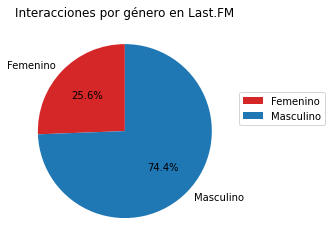

In [ ]:
fig, ax = plt.subplots()

gender = ['Femenino', 'Masculino']
bar_colors = ['tab:red', 'tab:blue']
ax.pie(lastFM_int_by_gender['count_gender'], autopct='%1.1f%%',
       labels=gender, startangle=90, colors=bar_colors)

ax.set_title('Interacciones por género en Last.FM', loc='center')
angle = np.deg2rad(0.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))
plt.savefig('lastFM_interacciones_by_gender.png')
plt.show()

Se tienen 3.290.838 interacciones de usuarios femeninos y 9.566.618 masculinos. Por lo que, la mayoría de las interacciones del dataset son de usuarios masculinos, siendo las interacciones de estos casi el triple de la de los usuarios femeninos.

Al agrupar los usuarios de Last.FM por edad tenemos que:

In [ ]:
lastFM_users_by_age = user_lastFM.groupby('age').size().to_frame('count_age')
lastFM_users_by_age

,count_age
age,
1.0,284
2.0,185
3.0,104
4.0,56
5.0,29
...,...
96.0,13
97.0,19
98.0,9


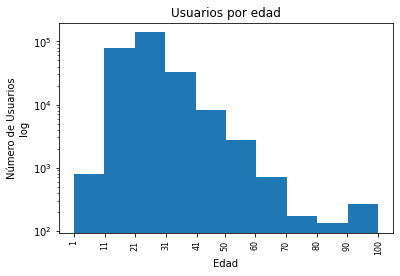

In [ ]:
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(lastFM_users_by_age.index, bins=10,
                                weights=lastFM_users_by_age.count_age)
ax.set_xticks(np.around(bins, decimals=0))
ax.set_xticklabels(labels=ax.get_xticks(), rotation=90, fontsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))

plt.subplots_adjust(bottom=0.15)
plt.xlabel('Edad')
plt.ylabel('Número de Usuarios\nlog')
plt.title(label='Usuarios por edad')
plt.yscale(value='log')
plt.show()

Al agrupar las interacciones de Last.FM por edad tenemos que:

In [ ]:
lastFM_plays_by_age = plays_lastFM.merge(user_lastFM, on='user_id').groupby('age').size().to_frame('count_age')
lastFM_plays_by_age

,count_age
age,
1.0,13898
2.0,8646
3.0,5074
4.0,2719
5.0,1375
...,...
96.0,589
97.0,940
98.0,430


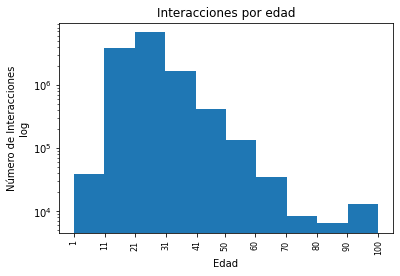

In [ ]:
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(lastFM_plays_by_age.index, bins=10,
                                weights=lastFM_plays_by_age.count_age)
ax.set_xticks(np.around(bins, decimals=0))
ax.set_xticklabels(labels=ax.get_xticks(), rotation=90, fontsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))

plt.subplots_adjust(bottom=0.15)
plt.xlabel('Edad')
plt.ylabel('Número de Interacciones\nlog')
plt.title(label='Interacciones por edad')
plt.yscale(value='log')
plt.show()

#### MovieLens 1M

In [ ]:
url_movieLens_items = 'https://drive.google.com/uc?export=download&id=1QqjmWpiKJ8-WdpUNZ6TWm50ALV8rR5qV'
url_movieLens_ratings = 'https://drive.google.com/uc?export=download&id=1FUvK6EoCYEk4suNwdbOqv-zOibD7SIE9'
url_movieLens_users = 'https://drive.google.com/uc?export=download&id=1SjBl7CImFUy_GZgkPXOHwTIRkJIMFfrb'

gdown.download(url_movieLens_items, 'movieLens.items', quiet=False)
gdown.download(url_movieLens_ratings, 'movieLens.ratings', quiet=False)
gdown.download(url_movieLens_users, 'movieLens.users', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1QqjmWpiKJ8-WdpUNZ6TWm50ALV8rR5qV
To: /content/movieLens.items
100%|██████████| 171k/171k [00:00<00:00, 69.0MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1FUvK6EoCYEk4suNwdbOqv-zOibD7SIE9
To: /content/movieLens.ratings
100%|██████████| 24.6M/24.6M [00:00<00:00, 192MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1SjBl7CImFUy_GZgkPXOHwTIRkJIMFfrb
To: /content/movieLens.users
100%|██████████| 134k/134k [00:00<00:00, 74.6MB/s]


'movieLens.users'

In [ ]:
movieLens_item_headers = ['item_id', 'name', 'category']
'''
MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist
'''
item_movieLens = pd.read_csv('movieLens.items', sep='::',  index_col = 0, names=movieLens_item_headers, encoding='latin-1')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
item_movieLens.head()

,name,category
item_id,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [ ]:
movieLens_rating_headers = ['user_id', 'movie_id', 'rating', 'timestamp']
'''
UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings
'''
rating_movieLens =  pd.read_csv('movieLens.ratings', sep='::',  index_col = None, names=movieLens_rating_headers)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
rating_movieLens.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
movieLens_user_headers = ['user_id', 'gender', 'age', 'occupation', 'zipcode']
'''

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"
'''
user_movieLens =  pd.read_csv('movieLens.users', sep='::',  index_col = 0, names=movieLens_user_headers)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
user_movieLens.head()

,gender,age,occupation,zipcode
user_id,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


Creamos un dataframe con los generos:

In [ ]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
    "(no genres listed)"]
genres_df = pd.DataFrame(genres, columns=['genres'])
genres_df.head()

,genres
0,Action
1,Adventure
2,Animation
3,Children
4,Comedy


Se modifica la tabla para tener los genres de las películas estén en columna.

In [ ]:
def set_genres(genres,col):
    if genres in col.split('|'): return 1
    else: return 0

In [ ]:
mov_genres_df = item_movieLens.copy()

In [ ]:
mov_genres_df['genres'] = mov_genres_df['category'].copy()

In [ ]:
# https://medium.com/@yesilliali/design-a-movie-recommendation-system-with-using-graph-database-neo4j-part-1-2c4933f4da0a
mov_genres_df["Action"] = mov_genres_df.apply(lambda x: set_genres("Action",x['genres']), axis=1)
mov_genres_df["Adventure"] = mov_genres_df.apply(lambda x: set_genres("Adventure",x['genres']), axis=1)
mov_genres_df["Animation"] = mov_genres_df.apply(lambda x: set_genres("Animation",x['genres']), axis=1)
mov_genres_df["Children"] = mov_genres_df.apply(lambda x: set_genres("Children",x['genres']), axis=1)
mov_genres_df["Comedy"] = mov_genres_df.apply(lambda x: set_genres("Comedy",x['genres']), axis=1)
mov_genres_df["Crime"] = mov_genres_df.apply(lambda x: set_genres("Crime",x['genres']), axis=1)
mov_genres_df["Documentary"] = mov_genres_df.apply(lambda x: set_genres("Documentary",x['genres']), axis=1)
mov_genres_df["Drama"] = mov_genres_df.apply(lambda x: set_genres("Drama",x['genres']), axis=1)
mov_genres_df["Fantasy"] = mov_genres_df.apply(lambda x: set_genres("Fantasy",x['genres']), axis=1)
mov_genres_df["Film-Noir"] = mov_genres_df.apply(lambda x: set_genres("Film-Noir",x['genres']), axis=1)
mov_genres_df["Horror"] = mov_genres_df.apply(lambda x: set_genres("Horror",x['genres']), axis=1)
mov_genres_df["Musical"] = mov_genres_df.apply(lambda x: set_genres("Musical",x['genres']), axis=1)
mov_genres_df["Mystery"] = mov_genres_df.apply(lambda x: set_genres("Mystery",x['genres']), axis=1)
mov_genres_df["Romance"] = mov_genres_df.apply(lambda x: set_genres("Romance",x['genres']), axis=1)
mov_genres_df["Sci-Fi"] = mov_genres_df.apply(lambda x: set_genres("Sci-Fi",x['genres']), axis=1)
mov_genres_df["Thriller"] = mov_genres_df.apply(lambda x: set_genres("Thriller",x['genres']), axis=1)
mov_genres_df["War"] = mov_genres_df.apply(lambda x: set_genres("War",x['genres']), axis=1)
mov_genres_df["Western"] = mov_genres_df.apply(lambda x: set_genres("Western",x['genres']), axis=1)
mov_genres_df["(no genres listed)"] = mov_genres_df.apply(lambda x: set_genres("(no genres listed)",x['genres']), axis=1)

In [ ]:
mov_genres_df = mov_genres_df.drop(columns=['category', 'genres'])
mov_genres_df

,name,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed)
item_id,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,Meet the Parents (2000),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3949,Requiem for a Dream (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3950,Tigerland (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
item_movieLens = mov_genres_df.copy()
item_movieLens.head()

,name,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed)
item_id,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Se comprueba que los datos de todas las tablas no tengan filas nulas.

In [ ]:
return_nan(user_movieLens)

,gender,age,occupation,zipcode
user_id,,,,


In [ ]:
return_nan(rating_movieLens)

,user_id,movie_id,rating,timestamp


In [ ]:
return_nan(item_movieLens)

,name,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed)
item_id,,,,,,,,,,,,,,,,,,,,


Se nota que no hay filas nulas, por lo que no se elimina ningun dato. Y que en total se tienen 6.040 usuarios que hicieron 1.000.209 interacciones/ratings sobre 3.883 items/películas.

In [ ]:
len(user_movieLens), len(rating_movieLens), len(item_movieLens)

(6040, 1000209, 3883)

Se guardan los dataframes con los datos limpios y organizados.

In [ ]:
user_movieLens.to_csv('movieLens_users.csv')
rating_movieLens.to_csv('movieLens_ratings.csv', index=False)
item_movieLens.to_csv('movieLens_items.csv')

A continuación se hace un análisis del genero de los 6.040 usuarios.

In [ ]:
movieLens_users_by_gender = user_movieLens.groupby('gender').size().to_frame('count_gender')
movieLens_users_by_gender

,count_gender
gender,
F,1709
M,4331


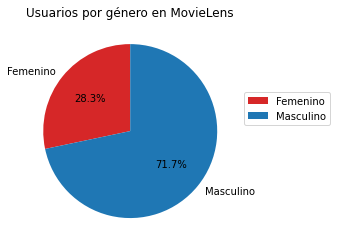

In [ ]:
fig, ax = plt.subplots()

gender = ['Femenino', 'Masculino']
bar_colors = ['tab:red', 'tab:blue']
ax.pie(movieLens_users_by_gender['count_gender'], autopct='%1.1f%%',
       labels=gender, startangle=90, colors=bar_colors)

ax.set_title('Usuarios por género en MovieLens', loc='center')
angle = np.deg2rad(0.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))
plt.savefig('movieLens_usuarios_by_gender.png')
plt.show()

Se tiene que en la tabla de usuarios 1.709 son femeninos y 4.331 masculinos, es decir, la cantidad de usuarios masculinos es más del doble que los femeninos.

A continuación, se analiza el genero de los usuarios que hicieron cada interacción.

In [ ]:
movieLens_rating_by_gender = rating_movieLens.merge(user_movieLens, on='user_id').groupby('gender').size().to_frame('count_gender')
movieLens_rating_by_gender

,count_gender
gender,
F,246440
M,753769


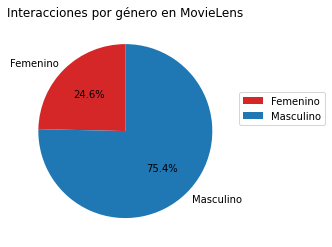

In [ ]:
fig, ax = plt.subplots()

gender = ['Femenino', 'Masculino']
bar_colors = ['tab:red', 'tab:blue']
ax.pie(movieLens_rating_by_gender['count_gender'], autopct='%1.1f%%',
       labels=gender, startangle=90, colors=bar_colors)

ax.set_title('Interacciones por género en MovieLens', loc='center')
angle = np.deg2rad(0.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))
plt.savefig('movieLens_interacciones_by_gender.png')
plt.show()

Al analizar lo anterior, se tiene que las interacciones hechas por usuarios femeninos son de 246.440 y las de masculino son 753.769, lo que acentua aún más la diferencia de datos, siendo tales que las interacciones masculinas son más del triple de las femeninas.

Ahora, al analizar, los usuarios por su grupo de edad, tenemos que:

In [ ]:
movieLens_users_by_age = user_movieLens.groupby('age').size().to_frame('count_age')
movieLens_users_by_age

,count_age
age,
1,222
18,1103
25,2096
35,1193
45,550
50,496
56,380


In [ ]:
movieLens_users_by_age['count_age']

age
1      222
18    1103
25    2096
35    1193
45     550
50     496
56     380
Name: count_age, dtype: int64

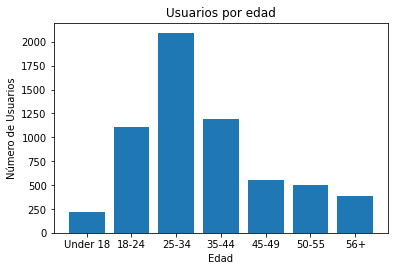

In [ ]:
labels_movie_age = ['Under 18','18-24','25-34','35-44','45-49','50-55','56+']
fig, ax = plt.subplots()
ax.bar(labels_movie_age, movieLens_users_by_age['count_age'])

plt.subplots_adjust(bottom=0.15)
plt.xlabel('Edad')
plt.ylabel('Número de Usuarios')
plt.title(label='Usuarios por edad')
plt.savefig('movieLens_usuarios_by_age.png')
plt.show()

In [ ]:
movieLens_rating_by_age = rating_movieLens.merge(user_movieLens, on='user_id').groupby('age').size().to_frame('count_age')
movieLens_rating_by_age

,count_age
age,
1,27211
18,183536
25,395556
35,199003
45,83633
50,72490
56,38780


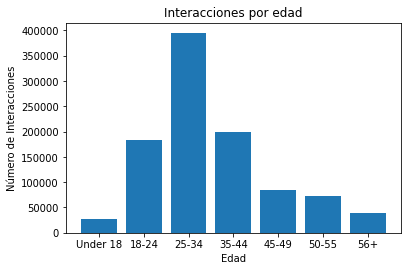

In [ ]:
labels_movie_age = ['Under 18','18-24','25-34','35-44','45-49','50-55','56+']
fig, ax = plt.subplots()
ax.bar(labels_movie_age, movieLens_rating_by_age['count_age'])

plt.subplots_adjust(bottom=0.15)
plt.xlabel('Edad')
plt.ylabel('Número de Interacciones')
plt.title(label='Interacciones por edad')
plt.savefig('movieLens_interacciones_by_age.png')
plt.show()